In [8]:
# import packages
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import auc
import os
from scipy.integrate import odeint
from scipy.signal import find_peaks, peak_prominences
import scipy.integrate as spi
import scipy.stats as st
from array import *
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator
import scipy.io as io
import math
import random
import pickle
from sklearn.metrics import r2_score
from scipy.interpolate import CubicSpline
from scipy import stats
#from ipynb.fs.full.All_Functions import GetPopParams
#from ipynb.fs.full.All_Functions import GetPopParamsOmega
#from ipynb.fs.full.All_Functions import GetVLIndParams
#from ipynb.fs.full.All_Functions import RandVLIndParams
#from ipynb.fs.full.All_Functions import RandVLParams
#from ipynb.fs.full.All_Functions import PKPDParams
#from ipynb.fs.full.All_Functions import Cohort_Prep
#from ipynb.fs.full.All_Functions import VLModel
#from ipynb.fs.full.All_Functions import VLPKPD
#from ipynb.fs.full.All_Functions import PK_Model
#from ipynb.fs.full.All_Functions import PD_Model
#from ipynb.fs.full.All_Functions import SetInit
#from ipynb.fs.full.All_Functions import SimulateTreatment
#from ipynb.fs.full.All_Functions import Trial_Simulation

#from ipynb.fs.full.All_Functions import SimulateTreatmentPK
#from ipynb.fs.full.All_Functions import TreatmentImpact
#from ipynb.fs.full.All_Functions import CI_Calc
%matplotlib inline

In [9]:
sns.__version__

'0.11.2'

In [10]:
data_File = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-FredHutchinsonCancerResearchCenter/Covid-19/Data/NBA_Panoramic_PLATCOV_MPV.csv'
Data_df = pd.read_csv(data_File)

NBA = Data_df[Data_df.cat_Cohort == 'NBA']
PLATCOV_Cntrl = Data_df[Data_df.cat_Cohort == 'PLATCOV']
PLATCOV_Trtmnt = Data_df[Data_df.cat_Cohort == 'PLATCOV_trtmnt']
Panoramic_Cntrl= Data_df[Data_df.cat_Cohort == 'Panoramic']
Panoramic_Trtmnt= Data_df[Data_df.cat_Cohort == 'Panoramic_trtmnt']

IDs_Tot = Data_df.ID.unique()
IDs_NBA = NBA.ID.unique()
IDs_Platcov_Cntrl = PLATCOV_Cntrl.ID.unique()
IDs_Platcov_trtmnt = PLATCOV_Trtmnt.ID.unique()

IDs_Panoramic_Cntrl = Panoramic_Cntrl.ID.unique()
IDs_Panoramic_trtmnt = Panoramic_Trtmnt.ID.unique()


IndParameters = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-FredHutchinsonCancerResearchCenter/Covid-19/Projects/NBA_Omicron_MPV_Panoramic_Platcov_Trial_tau_CovNBA_PLACntrl_Trtmtn_prf_est_Emax=1/IndividualParameters/estimatedIndividualParameters.txt'
#r'/Users/sesmaeil/Library/CloudStorage/OneDrive-FredHutchinsonCancerResearchCenter/Covid-19/Projects/NBA_Omicron_MPV_Panoramic_Platcov_Trial_tau_CovNBA_PLACntrl_Trtmtn_prf_est_Emax=1/IndividualParameters/estimatedIndividualParameters.txt'
PopParameters = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-FredHutchinsonCancerResearchCenter/Covid-19/Projects/NBA_Omicron_MPV_Panoramic_Platcov_Trial_tau_CovNBA_PLACntrl_Trtmtn_prf_est_Emax=1/IndividualParameters/estimatedIndividualParameters.txt'
#r'/Users/sesmaeil/Library/CloudStorage/OneDrive-FredHutchinsonCancerResearchCenter/Covid-19/Projects/NBA_Omicron_MPV_Panoramic_Platcov_Trial_tau_CovNBA_PLACntrl_Trtmtn_prf_est_Emax=1/populationParameters.txt'

parameters_df = pd.read_csv(IndParameters)
Popparameters_df = pd.read_csv(PopParameters)


Indparameters_MPV_file = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerResearchCenter/Schiffer Group - Shared Resources - SARSCoV2ComboModeling/PK-PD Modeling/MPVestimatedIndividualParameters.txt'
Popparameters_MPV_file = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerResearchCenter/Schiffer Group - Shared Resources - SARSCoV2ComboModeling/PK-PD Modeling/MPVpopulationParameters.txt'

Indparameters_MPV = pd.read_csv(Indparameters_MPV_file)
Popparameters_MPV = pd.read_csv(Popparameters_MPV_file)


In [11]:
import warnings
warnings.filterwarnings("ignore")

In [12]:
param_order = ['beta', 'phi', 'rho', 'k', 'delta', 'm', 'pi', 'c', 'tau']
fixed_params = dict({'c': 15, 'k':4})
param_dist = dict({'log10beta':'normal', 'log10phi':'normal', 'log10rho':'normal', 
                   'delta':'logNormal', 'h': 'logNormal', 'm': 'logNormal', 
                   'log10pi':'normal','tau': 'logNormal', 'tzero':'logitNormal',
                   'tzeromin': 0.75, 'tzeromax':20, 'Log10prf': 'normal'})


In [13]:
# Molnupiravir in vitro IC50
Emax = 1.00
IC50 = 0.177 #uMol
Hill = 2.05
PDOm = 0, 0.0, 0.0
MolMass = 329.31   #g/Mol
dose =800

In [14]:
def GetVLIndParams(parameters_df, ID, style = 'mode'):
    ''' 
    input:
        - data frame with parameter values as columns, individuals as rows
        - ID identifying individual of interest
        - style = 'mode' or 'mean' or 'SAEM' depending on which parameter values are preferred
    return:
        - dictionary with parameter names as key and parameter values as values
    '''
    i = ID
    cols = list(parameters_df)
    pid_params = parameters_df[parameters_df.id == i]
    values = []
    keys = []
    for c in cols:
        if style in c:
            k = c.split('_')[0]
            keys.append(k)
            v = pid_params[c].values[0]
            values.append(v)
    for i,(v,k) in enumerate(zip(values, keys)):
        if 'log10' in k:
            values[i] = 10**v
            keys[i] = k.split('0')[1]

    params = dict(zip(keys, values))
    return params

In [15]:
def ParamsPrep(Cohort, CohortStyle, GetVLIndParams, RandVLParams, parameters_df, Popparameters_df, fixed_params, param_order, param_dist,
               PKPDParams, Popparameters_PK, GetPopParams, GetPopParamsOmega, Emax, IC50, Hill,PDOm, dose):

    VLparams = []
    PKPD_params = []
    param_dict = []
    for ID in Cohort:
        if CohortStyle == 'direct':
            ind_params = GetVLIndParams(parameters_df, ID, style = 'mode')
        else:
            ind_params = RandVLParams(Popparameters_df, param_dist)
            
        _dict = {**fixed_params, **ind_params}
        param_dict.append(_dict)
        params = []
        for k in param_order:
            params.append(_dict[k])
        VLparams.append(params)
        pkpd =PKPDParams(Popparameters_PK, GetPopParams, GetPopParamsOmega, Emax, IC50, Hill, dose, PDOm)
        PKPD_params.append(pkpd)
    return VLparams, PKPD_params, param_dict

In [16]:
def PKPDParams(Popparameters, GetPopParams, GetParamsOmega, Emax, IC50, Hill, dose, PDOm):
    
    param_Order = ['ka', 'k12', 'k21', 'kcl', 'Vol', 'Emax', 'IC50', 'Hill']
    PKparams = GetPopParams(Popparameters, dose)
    PKparams_Val = PKparams['ka'], PKparams['kPL'], PKparams['kLP'], PKparams['kCl'],PKparams['Vol']
    PDparams = Emax, IC50, Hill
    PKPDparams = np.hstack((PKparams_Val, PDparams))
    
    PKOm = GetParamsOmega(Popparameters, dose)
    PKOm_Val = 0, 0, 0, 0, 0
    #PKOm['ka'], PKOm['kPL'], PKOm['kLP'], PKOm['kCl'],PKOm['Vol']
    PKPDOm = np.hstack((PKOm_Val, PDOm))
    eta = np.random.normal(np.zeros(len(PKPDOm)), PKPDOm, len(PKPDOm))
    PKPDInd = PKPDparams*np.exp(eta)
    if PKPDInd[5]>1:
        PKPDInd[5]=1
    return dict(zip(param_Order, PKPDInd))

In [17]:
def SetInit(param_dict):
    T_0 = 10**7
    R_0 = 0;
    E_0 = 0;
    I_0 = 0
    V_0 = param_dict['Vzero']
    Vm_0 = 0
    #param_dict['pi']*I_0/param_dict['c']
    return [T_0, R_0, E_0, I_0, V_0, Vm_0]

In [18]:
def Trial_Simulation_paramInput(TrtmntStrtDay, params, 
                                PKPDInd, param_dict, PotRed, MolMass, dose, SetInit, VLPKPD,
                               TreatmentLength = 5, TreatmentFrequency = 0.5):
        # import parameters
        # extract initial time
        t0 = -param_dict['tzero']
        # extract onset of symptoms from data
       # t_symp = filtered.SympOnsetDelay[filtered.ID == ID]
  #      TrtmntStrtDay = random.choice(range(0,4)) #treatment starting within 3 days of synptom onset
        t_end = 30 #duration of simulation 30 days after symptom onset. 
        #TrtmntStrtDay+14 # the duration of simulation (14 days after the start of treatment)
        init = SetInit(param_dict)
        init.extend([0,0,0])
        
        dosetimes = TrtmntStrtDay + np.arange(0,TreatmentLength,TreatmentFrequency)
     #   print(dosetimes[0])
     #   if (t0 > t_symp.values[0]):
      #      n=n+1
      #      continue
        t,y = SimulateTreatment(VLPKPD, init, t0, 0.001, t_end, params, PKPDInd, dose, dosetimes, PotRed, MolMass)
        return t, y, dosetimes

In [19]:
def VLPKPD(y, t, beta, phi, rho, k, delta, m, pi, c,tAI, ka, k12, kcl, k21,Vol, MolMass,E_max, IC50, Hill_Coeff):
    T,R,E,I,V,Vm, Ag, A1, A2 = y
    
    # PK model 
    dAg = -ka*Ag
    dA1 = ka*Ag+k21*A2-(kcl+k12)*A1
    dA2 = k12*A1-k21*A2   
    
    # PD model 
    conc = np.maximum(A1,10**-8)*10**6/Vol/MolMass # # convert to from mg/mL to micromolar
    epsM = np.divide(np.multiply(E_max,np.power(conc,Hill_Coeff)),(np.power(IC50, Hill_Coeff)+np.power(conc,Hill_Coeff)))
        
    # within-host treatment model
    if t > tAI:
        m_AI = m
    else:
        m_AI = 0
    
    
    ddt_T = -beta*T*V - phi*I*T + rho*R
    ddt_R = phi*I*T -rho*R
    ddt_E = beta*T*V - k*E
    ddt_I = k*E - delta*I - m_AI*I
    if I>=1:
        ddt_V = (1-epsM)*pi*I-c*V
        ddt_Vm = epsM*pi*I-c*Vm
    else:
        ddt_V = -c*V
        ddt_Vm = -c*Vm

    return  ddt_T, ddt_R, ddt_E, ddt_I, ddt_V, ddt_Vm, dAg, dA1, dA2


In [20]:
def SimulateTreatment(VLPKPD, init, tzero, dt, tend, params, PKPDInd, dose, dosetimes, PotRed, MolMass):
    #Nirmatrelvir PD parameters
    E_max = PKPDInd['Emax']
    Hill_Coeff = PKPDInd['Hill']
    IC50 = PotRed*PKPDInd['IC50']

    #Nirmatrelvir PK Parameters for each individual
    ka = PKPDInd['ka']
    k12 = PKPDInd['k12']
    k21 = PKPDInd['k21']
    kcl = PKPDInd['kcl']
    Vol = PKPDInd['Vol']
    params_local = params.copy()
    params_local.extend([ka, k12, kcl, k21,Vol, MolMass, E_max, IC50, Hill_Coeff])
    args = tuple(params_local)
  
    if tzero==dosetimes[0]:
        for j in range(0,len(dosetimes)-1):
            init[6] = init[6] + dose 
            ttemp = np.arange(dosetimes[j],dosetimes[j+1],dt)
            ytemp = spi.odeint(VLPKPD, init, ttemp, args = args)
            init = ytemp[-1,:].T
            if j==0:
                y= ytemp.copy()
                t= ttemp.copy()
            else:
                y = np.concatenate((y,ytemp), axis=0)
                t = np.concatenate((t,ttemp))
    else:       
        
        # simulate infection from tzero up to 1st dose
        t = np.arange(tzero, dosetimes[0],dt)
        # simulate using scipy integrate
        y = spi.odeint(VLPKPD, init, t, args = args)
   
        ytemp = y.copy()

        #loop through dose values
        for j in range(0,len(dosetimes)-1):
            init = ytemp[-1,:].T
            init[6] = init[6] + dose 
            ttemp = np.arange(dosetimes[j],dosetimes[j+1],dt)
        
            ytemp = spi.odeint(VLPKPD, init, ttemp, args = args)
            t=np.concatenate((t,ttemp))
            y=np.concatenate((y,ytemp),axis=0)        
    #simulate until tend
    init = ytemp[-1,:].T
    init[6] = init[6] + dose 
    ttemp = np.arange(dosetimes[-1],tend,dt)
    ytemp = spi.odeint(VLPKPD, init, ttemp, args = args)
    t=np.concatenate((t,ttemp))
    y=np.concatenate((y,ytemp),axis=0)  
    return t, y

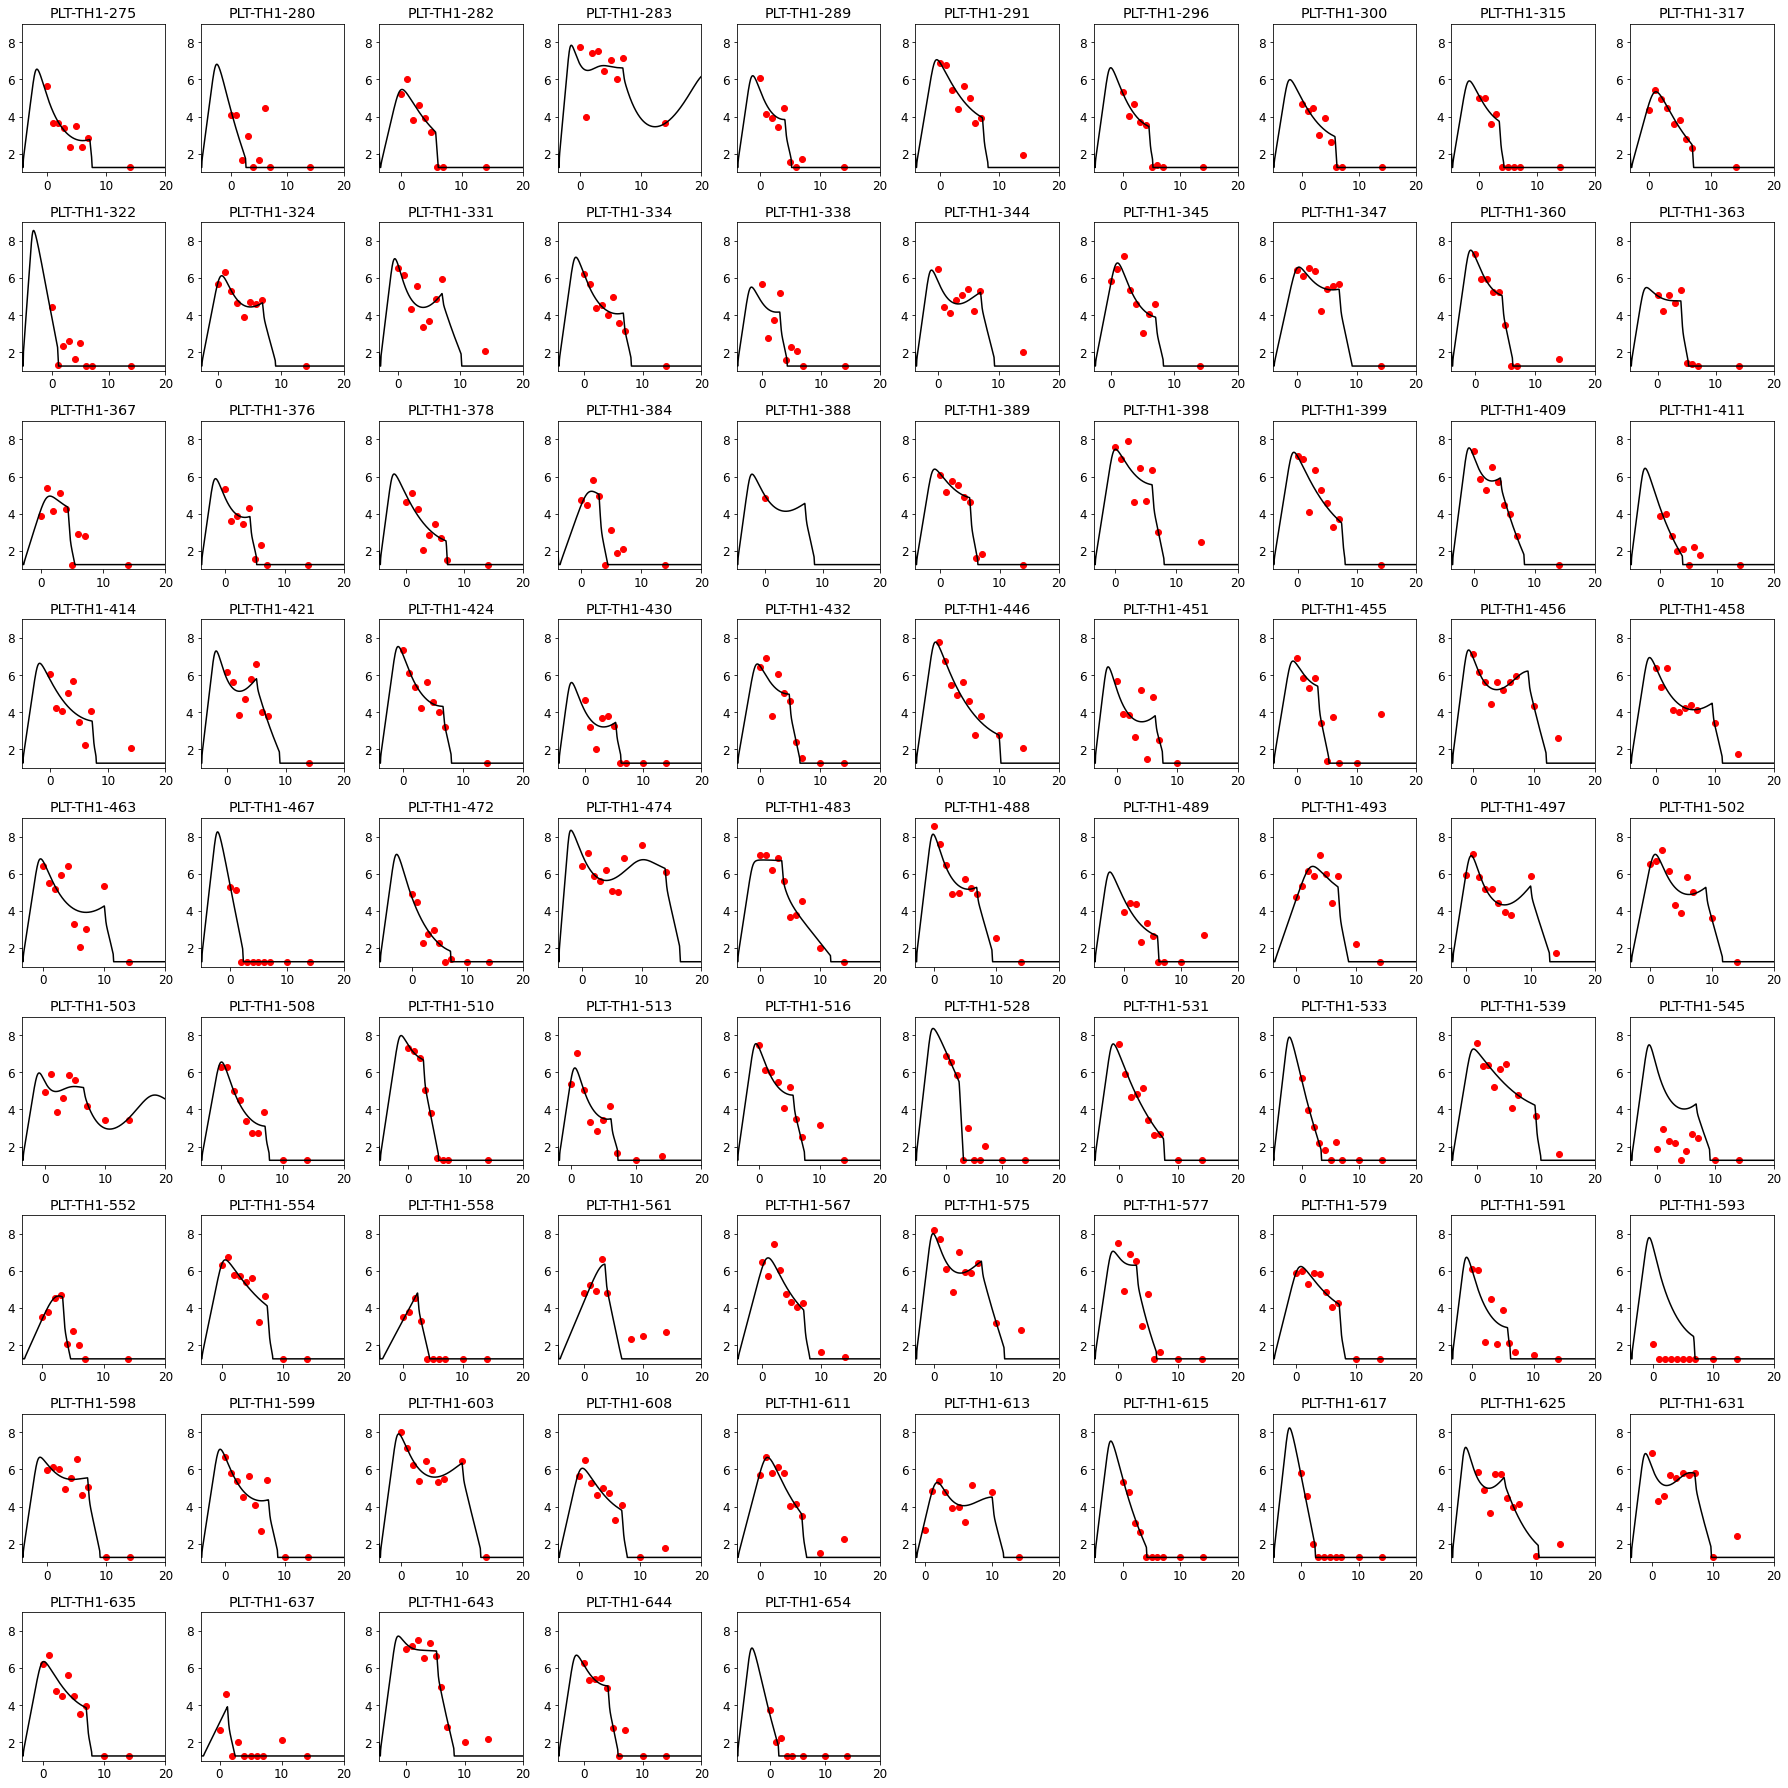

In [21]:
fig = plt.figure(figsize = (25,25))
plt.rcParams.update({'font.size': 12})
Cohort = IDs_Platcov_Cntrl
dose = 0
TreatmntStrtDay = np.zeros(len(Cohort))
drop_VL_PLATCOV_cntrl=[]
AUC_PLATCOV_Cntrl = []
VLInd, PKPD_Params, param_dict = ParamsPrep(Cohort, 'direct', GetVLIndParams, RandVLParams, 
                                            parameters_df, Popparameters_df, fixed_params, 
                                            param_order, param_dist, PKPDParams, 
                                            Popparameters_MPV, GetPopParams, GetPopParamsOmega, Emax, 
                                            IC50, Hill,PDOm, dose=8*10**8)
for idi, ID, TrtmntStrtDay in zip(range(0,len(Cohort)), Cohort, TreatmntStrtDay):
        

        t, y, dosetimes= Trial_Simulation_paramInput(TrtmntStrtDay, VLInd[idi][:], PKPD_Params[idi], param_dict[idi], 
                                                             10**param_dict[idi]['Log10prf'], MolMass, dose, SetInit, VLPKPD,
                                                             TreatmentLength = 5, TreatmentFrequency = 0.5)
       
        data = PLATCOV_Cntrl[PLATCOV_Cntrl.ID == ID]
        data_t = data['time']
        data_y = data['y']
        T,R,E,I,V, Vm, Ag, A1, A2 = y.T
        X = np.log10(np.maximum(V+Vm,10**1.26))
        tstart = np.argwhere(t>=TrtmntStrtDay)[0][0]
        tend = np.argwhere(t>=TrtmntStrtDay+15)[0][0]
        t5 = np.argwhere(t>=TrtmntStrtDay+5)[0][0]
        drop_VL_PLATCOV_cntrl.append(X[tstart:tend]-X[tstart])
        AUC_PLATCOV_Cntrl.append(auc(t[tstart:t5], X[tstart:t5]))
        plt.subplot(9,10, idi+1)
        plt.plot(data_t, data_y, 'o', color = 'r')
        plt.plot(t, X, color = 'black')
        plt.xlim([-param_dict[idi]['tzero'], 20])
        plt.ylim([1,9])
        plt.title(ID)
        plt.tight_layout()
Mean_drop_VL_TotPop_Cntrl_PLATCOV=np.mean(drop_VL_PLATCOV_cntrl, axis=0)

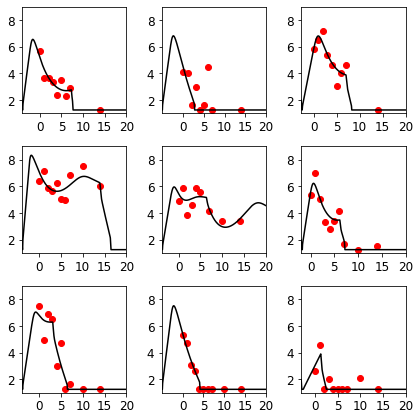

In [22]:
fig = plt.figure(figsize = (6,6))
plt.rcParams.update({'font.size': 12})
Cohort = IDs_Platcov_Cntrl
dose = 0
TreatmntStrtDay = np.zeros(len(Cohort))
VLInd, PKPD_Params, param_dict = ParamsPrep(Cohort, 'direct', GetVLIndParams, RandVLParams, 
                                            parameters_df, Popparameters_df, fixed_params, 
                                            param_order, param_dist, PKPDParams, 
                                            Popparameters_MPV, GetPopParams, GetPopParamsOmega, Emax, 
                                            IC50, Hill,PDOm, dose=8*10**8)
IDs = ['PLT-TH1-275', 'PLT-TH1-280', 'PLT-TH1-345', 'PLT-TH1-474', 'PLT-TH1-513', 
       'PLT-TH1-637','PLT-TH1-503', 'PLT-TH1-615', 'PLT-TH1-577']
idis = [i for i in range(len(Cohort)) if Cohort[i] in IDs]
i=0
for idi, ID, TrtmntStrtDay in zip(idis, Cohort[idis], TreatmntStrtDay[idis]):
        


        t, y, dosetimes= Trial_Simulation_paramInput(TrtmntStrtDay, VLInd[idi][:], PKPD_Params[idi], param_dict[idi], 
                                                             10**param_dict[idi]['Log10prf'], MolMass, dose, SetInit, VLPKPD,
                                                             TreatmentLength = 5, TreatmentFrequency = 0.5)
        data = PLATCOV_Cntrl[PLATCOV_Cntrl.ID == ID]
        data_t = data['time']
        data_y = data['y']
        T,R,E,I,V,Vm,  Ag, A1, A2 = y.T
        X = np.log10(np.maximum(V+Vm,10**1.26))
        plt.subplot(3,3, i+1)
        plt.plot(data_t, data_y, 'o', color = 'r')
        plt.plot(t, X, color = 'black')
        plt.xlim([-param_dict[idi]['tzero'], 20])
        plt.ylim([1,9])
        plt.xticks([0,5,10,15,20])
       # plt.title(ID)
        plt.tight_layout()
        i=i+1

{'c': 15, 'k': 4, 'beta': 5.236607217839772e-08, 'pi': 1027.637632682961, 'rho': 0.20356026144837147, 'phi': 2.2063276110841722e-05, 'delta': 2.33476, 'm': 24.645, 'tau': 5.99511, 'tzero': 4.52073, 'Vzero': 97, 'Log10prf': -1.03207}


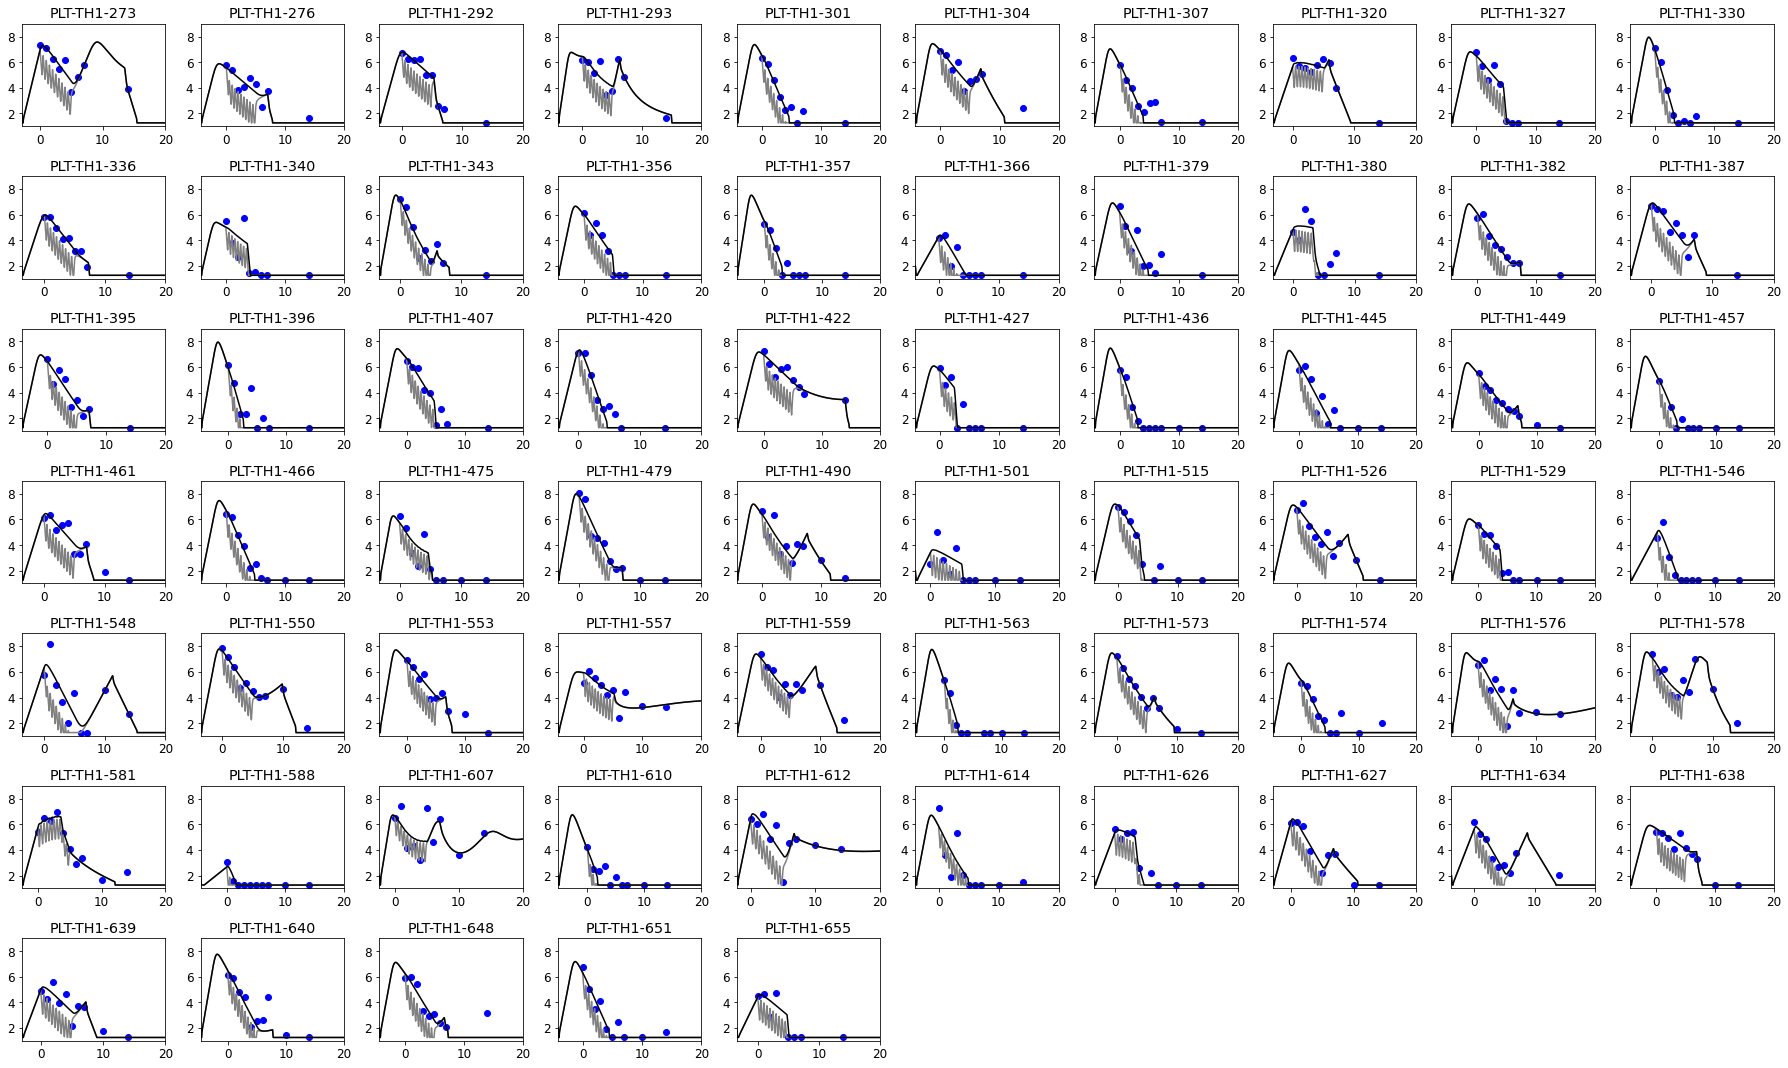

In [45]:
fig = plt.figure(figsize = (25,15))
plt.rcParams.update({'font.size': 12})
Cohort = IDs_Platcov_trtmnt
dose = 800
drop_VL_PLATCOV_trtmnt = []
active_drop_VL_PLATCOV_trtmnt = []
AUC_PLATCOV_Trtmnt = []
Active_AUC_PLATCOV_Trtmnt = []
TreatmntStrtDay = np.zeros(len(Cohort))
VLInd, PKPD_Params, param_dict = ParamsPrep(Cohort, 'direct', GetVLIndParams, RandVLParams, 
                                            parameters_df, Popparameters_df, fixed_params, 
                                            param_order, param_dist, PKPDParams, 
                                            Popparameters_MPV, GetPopParams, GetPopParamsOmega, Emax, 
                                            IC50, Hill,PDOm, dose=8*10**8)
for idi, ID, TrtmntStrtDay in zip(range(0,len(Cohort)), Cohort, TreatmntStrtDay):
        
    
        t, y, dosetimes= Trial_Simulation_paramInput(TrtmntStrtDay, VLInd[idi][:], PKPD_Params[idi], param_dict[idi], 
                                                             10**param_dict[idi]['Log10prf'], MolMass, dose, SetInit, VLPKPD,
                                                             TreatmentLength = 5, TreatmentFrequency = 0.5)
        if ID == 'PLT-TH1-576':
            print(param_dict[idi])
        data = PLATCOV_Trtmnt[PLATCOV_Trtmnt.ID == ID]
        data_t = data['time']
        data_y = data['y']
        T,R,E,I,V, Vm, Ag, A1, A2 = y.T
        X = np.log10(np.maximum(V+Vm,10**1.26))
        X_active = np.log10(np.maximum(V,10**1.26))
        tstart = np.argwhere(t>=TrtmntStrtDay)[0][0]
        tend = np.argwhere(t>=TrtmntStrtDay+15)[0][0]
        t5 = np.argwhere(t>=TrtmntStrtDay+5)[0][0]
        drop_VL_PLATCOV_trtmnt.append(X[tstart:tend]-X[tstart])
        active_drop_VL_PLATCOV_trtmnt.append(X_active[tstart:tend]-X_active[tstart])
        AUC_PLATCOV_Trtmnt.append(auc(t[tstart:t5],X[tstart:t5]))
        Active_AUC_PLATCOV_Trtmnt.append(auc(t[tstart:t5],X_active[tstart:t5]))
        plt.subplot(7,10, idi+1)
        plt.plot(data_t, data_y, 'o', color = 'b')
        plt.plot(t, X_active, color = 'grey')
        plt.plot(t, X, color = 'black')
        
        plt.xlim([-param_dict[idi]['tzero'], 20])
        plt.ylim([1, 9])
        plt.title(ID)
        plt.tight_layout()
        
Mean_drop_VL_TotPop_Trtmnt_PLATCOV=np.mean(drop_VL_PLATCOV_trtmnt, axis=0)
Active_Mean_drop_VL_TotPop_Trtmnt_PLATCOV=np.mean(active_drop_VL_PLATCOV_trtmnt, axis=0)

In [53]:
pickle.dump(drop_VL_PLATCOV_cntrl, open('TotVdrop_Cntrl_PLATCOV_trialpartis.pickle', 'wb')) 
pickle.dump(drop_VL_PLATCOV_trtmnt, open('TotVdrop_PLATCOV_trialpartis.pickle', 'wb')) 
pickle.dump(active_drop_VL_PLATCOV_trtmnt, open('activeVdrop_PLATCOV_trialpartis.pickle', 'wb'))

pickle.dump(AUC_PLATCOV_Cntrl, open('AUC_Cntrl_PLATCOV_trialpartis.pickle', 'wb')) 
pickle.dump(AUC_PLATCOV_Trtmnt, open('AUC_PLATCOV_trialpartis.pickle', 'wb')) 
pickle.dump(Active_AUC_PLATCOV_Trtmnt, open('activeAUC_PLATCOV_trialpartis.pickle', 'wb'))

In [47]:
t_5 = np.argwhere(np.linspace(0, 14.999, 15000)>=5)[0][0]

In [48]:
Mean_drop_VL_TotPop_Trtmnt_PLATCOV[t_5]

-3.473644487366251

In [49]:
Mean_drop_VL_TotPop_Cntrl_PLATCOV[t_5]

-2.206898779559571

In [50]:
Mean_drop_VL_TotPop_Cntrl_PLATCOV[t_5]-Active_Mean_drop_VL_TotPop_Trtmnt_PLATCOV[t_5]

1.7533673112737058

In [51]:
Mean_drop_VL_TotPop_Cntrl_PLATCOV[t_5]-Mean_drop_VL_TotPop_Trtmnt_PLATCOV[t_5]

1.2667457078066802

In [52]:
Mean_drop_VL_TotPop_Trtmnt_PLATCOV[t_5]-Active_Mean_drop_VL_TotPop_Trtmnt_PLATCOV[t_5]

0.48662160346702565

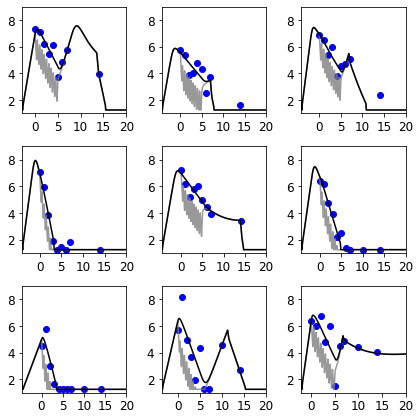

In [15]:
fig = plt.figure(figsize = (6,6))
plt.rcParams.update({'font.size': 12})
Cohort = IDs_Platcov_trtmnt
dose = 800
TreatmntStrtDay = np.zeros(len(Cohort))
VLInd, PKPD_Params, param_dict = ParamsPrep(Cohort, 'direct', GetVLIndParams, RandVLParams, 
                                            parameters_df, Popparameters_df, fixed_params, 
                                            param_order, param_dist, PKPDParams, 
                                            Popparameters_MPV, GetPopParams, GetPopParamsOmega, Emax, 
                                            IC50, Hill,PDOm, dose=8*10**8)
IDs = ['PLT-TH1-276', 'PLT-TH1-304', 'PLT-TH1-422', 'PLT-TH1-273', 'PLT-TH1-466', 
       'PLT-TH1-546', 'PLT-TH1-612', 'PLT-TH1-548', 'PLT-TH1-330']
idis = [i for i in range(len(Cohort)) if Cohort[i] in IDs]
i=0
for idi, ID, TrtmntStrtDay in zip(idis, Cohort[idis], TreatmntStrtDay[idis]):
        

        t, y, dosetimes= Trial_Simulation_paramInput(TrtmntStrtDay, VLInd[idi][:], PKPD_Params[idi], param_dict[idi], 
                                                             10**param_dict[idi]['Log10prf'], MolMass, dose, SetInit, VLPKPD,
                                                             TreatmentLength = 5, TreatmentFrequency = 0.5)
        data = PLATCOV_Trtmnt[PLATCOV_Trtmnt.ID == ID]
        data_t = data['time']
        data_y = data['y']
        T,R,E,I,V, Vm, Ag, A1, A2 = y.T
        X = np.log10(np.maximum(V+Vm,10**1.26))
        X_active = np.log10(np.maximum(V,10**1.26))
        plt.subplot(3,3, i+1)
        plt.plot(data_t, data_y, 'o', color = 'b')
        plt.plot(t, X_active, color = 'grey', alpha=0.8)
        plt.plot(t, X, color = 'black')
        plt.xlim([-param_dict[idi]['tzero'], 20])
        plt.ylim([1, 9])
        plt.xticks([0, 5, 10, 15,20])
       # plt.title(ID)
        plt.tight_layout()
        i = i+1

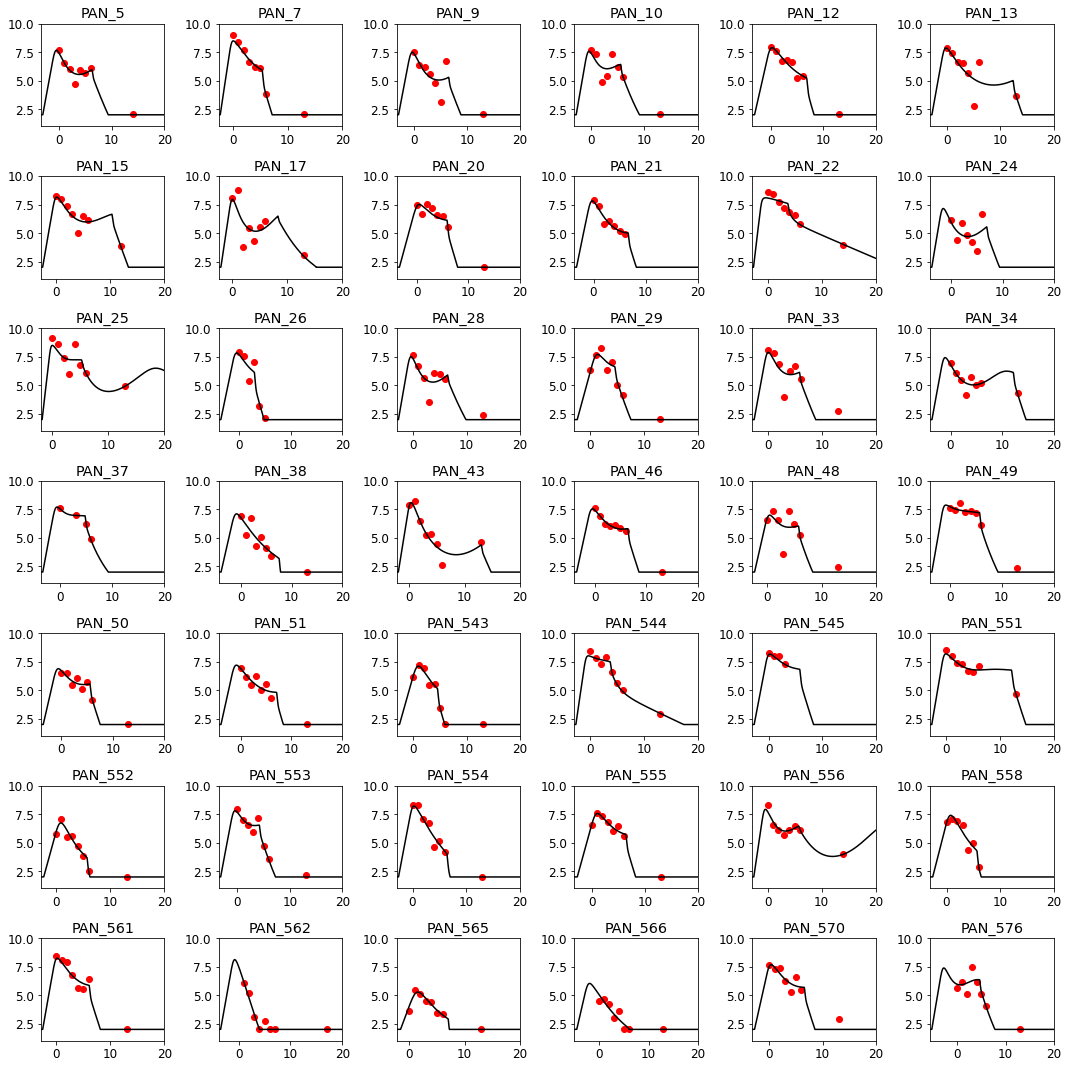

In [54]:
fig = plt.figure(figsize = (15,15))
plt.rcParams.update({'font.size': 12})
Cohort = IDs_Panoramic_Cntrl
dose = 0
TreatmntStrtDay = np.zeros(len(Cohort))
drop_VL_cntrl=[]
AUC_PANORAMIC_Cntrl=[]
VLInd, PKPD_Params, param_dict = ParamsPrep(Cohort, 'direct', GetVLIndParams, RandVLParams, 
                                            parameters_df, Popparameters_df, fixed_params, 
                                            param_order, param_dist, PKPDParams, 
                                            Popparameters_MPV, GetPopParams, GetPopParamsOmega, Emax, 
                                            IC50, Hill,PDOm, dose=8*10**8)
for idi, ID, TrtmntStrtDay in zip(range(0,len(Cohort)), Cohort, TreatmntStrtDay):
        

        t, y, dosetimes= Trial_Simulation_paramInput(TrtmntStrtDay, VLInd[idi][:], PKPD_Params[idi], param_dict[idi], 
                                                             10**param_dict[idi]['Log10prf'], MolMass, dose, SetInit, VLPKPD,
                                                             TreatmentLength = 5, TreatmentFrequency = 0.5)
       
        data = Panoramic_Cntrl[Panoramic_Cntrl.ID == ID]
        data_t = data['time']
        data_y = data['y']
        T,R,E,I,V, Vm, Ag, A1, A2 = y.T
        X = np.log10(np.maximum(V+Vm,10**2))
        tstart = np.argwhere(t>=TrtmntStrtDay)[0][0]
        tend = np.argwhere(t>=TrtmntStrtDay+15)[0][0]
        t5 = np.argwhere(t>=TrtmntStrtDay+5)[0][0]
        drop_VL_cntrl.append(X[tstart:tend]-X[tstart])
        AUC_PANORAMIC_Cntrl.append(auc(t[tstart:t5], X[tstart:t5]))
        plt.subplot(7,6, idi+1)
        plt.plot(data_t, data_y, 'o', color = 'r')
        plt.plot(t, X, color = 'black')
        plt.xlim([-param_dict[idi]['tzero'], 20])
        plt.ylim([1,10])
        plt.title(ID)
        plt.tight_layout()
        
Mean_drop_VL_TotPop_Cntrl_Panoramic=np.mean(drop_VL_cntrl, axis=0)

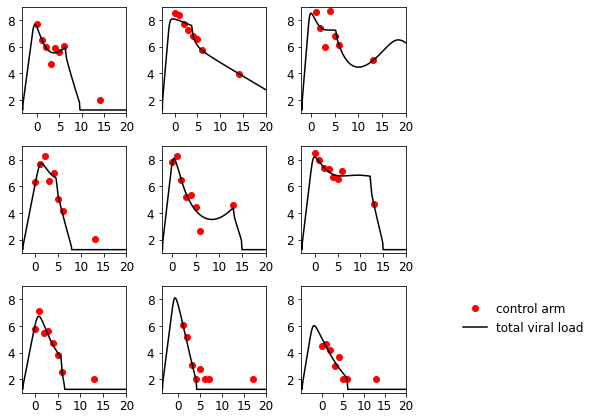

In [16]:
fig = plt.figure(figsize = (6,6))
plt.rcParams.update({'font.size': 12})
Cohort = IDs_Panoramic_Cntrl
dose = 0
TreatmntStrtDay = np.zeros(len(Cohort))
VLInd, PKPD_Params, param_dict = ParamsPrep(Cohort, 'direct', GetVLIndParams, RandVLParams, 
                                            parameters_df, Popparameters_df, fixed_params, 
                                            param_order, param_dist, PKPDParams, 
                                            Popparameters_MPV, GetPopParams, GetPopParamsOmega, Emax, 
                                            IC50, Hill,PDOm, dose=8*10**8)
IDs = ['PAN_5', 'PAN_22', 'PAN_25', 'PAN_29', 'PAN_43', 
       'PAN_551','PAN_562', 'PAN_552', 'PAN_566']
idis = [i for i in range(len(Cohort)) if Cohort[i] in IDs]
i=0
for idi, ID, TrtmntStrtDay in zip(idis, Cohort[idis], TreatmntStrtDay[idis]):
        


        t, y, dosetimes= Trial_Simulation_paramInput(TrtmntStrtDay, VLInd[idi][:], PKPD_Params[idi], param_dict[idi], 
                                                             10**param_dict[idi]['Log10prf'], MolMass, dose, SetInit, VLPKPD,
                                                             TreatmentLength = 5, TreatmentFrequency = 0.5)
        data = Panoramic_Cntrl[Panoramic_Cntrl.ID == ID]
        data_t = data['time']
        data_y = data['y']
        T,R,E,I,V,Vm,  Ag, A1, A2 = y.T
        X = np.log10(np.maximum(V+Vm,10**1.26))
        plt.subplot(3,3, i+1)
        plt.plot(data_t, data_y, 'o', color = 'r', label = 'control arm')
        plt.plot(t, X, color = 'black', label = 'total viral load')
        plt.xlim([-param_dict[idi]['tzero'], 20])
        plt.ylim([1,9])
        plt.xticks([0,5,10,15,20])
       # plt.title(ID)
        plt.tight_layout()
        i=i+1
        if i==9:
            plt.legend(frameon=False, loc = [1.5,0.5])

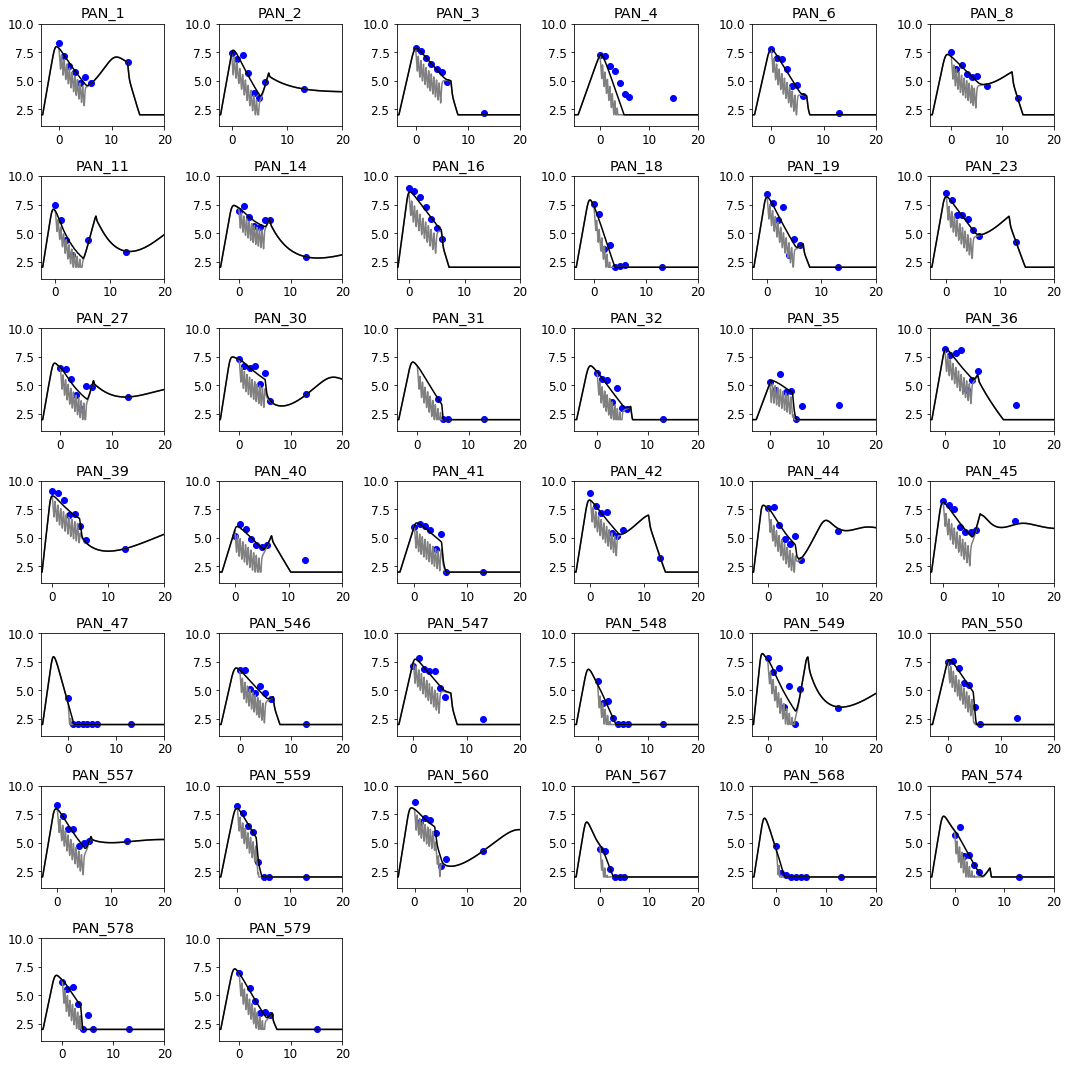

In [55]:
fig = plt.figure(figsize = (15,15))
plt.rcParams.update({'font.size': 12})
Cohort = IDs_Panoramic_trtmnt
dose = 800
drop_VL_trtmnt = []
drop_VL_active_trtmnt=[]
AUC_PANORAMIC_Trtmnt = []
Active_AUC_PANORAMIC_Trtmnt = []
TreatmntStrtDay = np.zeros(len(Cohort))
VLInd, PKPD_Params, param_dict = ParamsPrep(Cohort, 'direct', GetVLIndParams, RandVLParams, 
                                            parameters_df, Popparameters_df, fixed_params, 
                                            param_order, param_dist, PKPDParams, 
                                            Popparameters_MPV, GetPopParams, GetPopParamsOmega, Emax, 
                                            IC50, Hill,PDOm, dose=8*10**8)
for idi, ID, TrtmntStrtDay in zip(range(0,len(Cohort)), Cohort, TreatmntStrtDay):
        
    
        t, y, dosetimes= Trial_Simulation_paramInput(TrtmntStrtDay, VLInd[idi][:], PKPD_Params[idi], param_dict[idi], 
                                                             10**param_dict[idi]['Log10prf'], MolMass, dose, SetInit, VLPKPD,
                                                             TreatmentLength = 5, TreatmentFrequency = 0.5)
        
       
       
        data = Panoramic_Trtmnt[Panoramic_Trtmnt.ID == ID]
        data_t = data['time']
        data_y = data['y']
        T,R,E,I,V, Vm, Ag, A1, A2 = y.T
        
        X = np.log10(np.maximum(V+Vm,10**2))
        X_active = np.log10(np.maximum(V,10**2))
        tstart = np.argwhere(t>=TrtmntStrtDay)[0][0]
        tend = np.argwhere(t>=TrtmntStrtDay+15)[0][0]
        t5 = np.argwhere(t>=TrtmntStrtDay+5)[0][0]
        drop_VL_trtmnt.append(X[tstart:tend]-X[tstart])
        drop_VL_active_trtmnt.append(X_active[tstart:tend]-X_active[tstart])
        AUC_PANORAMIC_Trtmnt.append(auc(t[tstart:t5], X[tstart:t5]))
        Active_AUC_PANORAMIC_Trtmnt.append(auc(t[tstart:t5], X_active[tstart:t5]))
        plt.subplot(7,6, idi+1)
        plt.plot(data_t, data_y, 'o', color = 'b')
        plt.plot(t, X_active, color = 'grey')
        plt.plot(t, X, color = 'black')

        
        plt.xlim([-param_dict[idi]['tzero'], 20])
        plt.ylim([1, 10])
        plt.title(ID)
        plt.tight_layout()
Mean_drop_VL_TotPop_Trtmnt_Panoramic=np.mean(drop_VL_trtmnt, axis=0)    
Active_Mean_drop_VL_TotPop_Trtmnt_Panoramic=np.mean(drop_VL_active_trtmnt, axis=0)   

In [56]:
pickle.dump(drop_VL_cntrl, open('TotVdrop_Cntrl_PANORAMIC_trialpartis.pickle', 'wb')) 
pickle.dump(drop_VL_trtmnt, open('TotVdrop_PANORAMIC_trialpartis.pickle', 'wb')) 
pickle.dump(drop_VL_active_trtmnt, open('activeVdrop_PANORAMIC_trialpartis.pickle', 'wb'))

pickle.dump(AUC_PANORAMIC_Cntrl, open('AUC_Cntrl_PANORAMIC_trialpartis.pickle', 'wb')) 
pickle.dump(AUC_PANORAMIC_Trtmnt, open('AUC_PANORAMIC_trialpartis.pickle', 'wb')) 
pickle.dump(Active_AUC_PANORAMIC_Trtmnt, open('activeAUC_PANORAMIC_trialpartis.pickle', 'wb'))

In [57]:
Mean_drop_VL_TotPop_Cntrl_Panoramic[t_5]

-2.0048632035256566

In [58]:
Mean_drop_VL_TotPop_Trtmnt_Panoramic[t_5]

-3.211140835084512

In [59]:
Active_Mean_drop_VL_TotPop_Trtmnt_Panoramic[t_5]

-3.8067661421582657

In [61]:
Mean_drop_VL_TotPop_Cntrl_Panoramic[t_5]-Mean_drop_VL_TotPop_Trtmnt_Panoramic[t_5]

1.2062776315588555

In [62]:
Mean_drop_VL_TotPop_Cntrl_Panoramic[t_5]-Active_Mean_drop_VL_TotPop_Trtmnt_Panoramic[t_5]

1.801902938632609

In [63]:
Mean_drop_VL_TotPop_Trtmnt_Panoramic[t_5]-Active_Mean_drop_VL_TotPop_Trtmnt_Panoramic[t_5]

0.5956253070737536

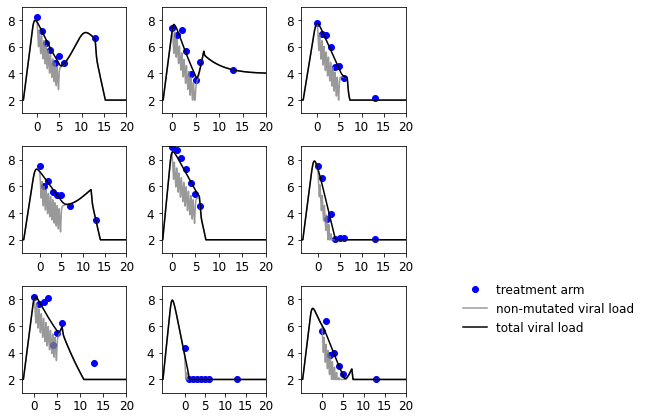

In [17]:
fig = plt.figure(figsize = (6,6))
plt.rcParams.update({'font.size': 12})
Cohort = IDs_Panoramic_trtmnt
dose = 800
TreatmntStrtDay = np.zeros(len(Cohort))
VLInd, PKPD_Params, param_dict = ParamsPrep(Cohort, 'direct', GetVLIndParams, RandVLParams, 
                                            parameters_df, Popparameters_df, fixed_params, 
                                            param_order, param_dist, PKPDParams, 
                                            Popparameters_MPV, GetPopParams, GetPopParamsOmega, Emax, 
                                            IC50, Hill,PDOm, dose=8*10**8)
IDs = ['PAN_1', 'PAN_2', 'PAN_6', 'PAN_8', 'PAN_16', 
       'PAN_18', 'PAN_36', 'PAN_47', 'PAN_574']
idis = [i for i in range(len(Cohort)) if Cohort[i] in IDs]
i=0
for idi, ID, TrtmntStrtDay in zip(idis, Cohort[idis], TreatmntStrtDay[idis]):
        

        t, y, dosetimes= Trial_Simulation_paramInput(TrtmntStrtDay, VLInd[idi][:], PKPD_Params[idi], param_dict[idi], 
                                                             10**param_dict[idi]['Log10prf'], MolMass, dose, SetInit, VLPKPD,
                                                             TreatmentLength = 5, TreatmentFrequency = 0.5)
        data = Panoramic_Trtmnt[Panoramic_Trtmnt.ID == ID]
        data_t = data['time']
        data_y = data['y']
        T,R,E,I,V, Vm, Ag, A1, A2 = y.T
        X = np.log10(np.maximum(V+Vm,10**2))
        X_active = np.log10(np.maximum(V,10**2))
        plt.subplot(3,3, i+1)
        plt.plot(data_t, data_y, 'o', color = 'b', label = 'treatment arm')
        plt.plot(t, X_active, color = 'grey', alpha=0.8, label = 'non-mutated viral load')
        plt.plot(t, X, color = 'black', label = 'total viral load')
        plt.xlim([-param_dict[idi]['tzero'], 20])
        plt.ylim([1, 9])
        plt.xticks([0, 5, 10, 15,20])
       # plt.title(ID)
        plt.tight_layout()
        i = i+1
        if i==9:
            plt.legend(frameon=False, loc = [1.5,0.5])

In [23]:
Cohort = np.hstack([IDs_Platcov_Cntrl, IDs_Platcov_trtmnt,IDs_Panoramic_Cntrl, IDs_Panoramic_trtmnt])

params =[]
dose = 800
VLInd, PKPD_Params, param_dict = ParamsPrep(Cohort, 'direct', GetVLIndParams, RandVLParams, 
                                            parameters_df, Popparameters_df, fixed_params, 
                                            param_order, param_dist, PKPDParams, 
                                            Popparameters_MPV, GetPopParams, GetPopParamsOmega, Emax, 
                                            IC50, Hill,PDOm, dose)

for idi, ID in enumerate(Cohort):
    if ID in IDs_Platcov_trtmnt:
        param_dict[idi]['Cohort'] = 'PLATCOV_Trtmnt'
    elif ID in IDs_Platcov_Cntrl:
        param_dict[idi]['Cohort'] = 'PLATCOV_Cntrl'
    elif ID in IDs_Panoramic_trtmnt:
        param_dict[idi]['Cohort'] = 'Panoramic_Trtmnt'
    elif ID in IDs_Panoramic_Cntrl:
        param_dict[idi]['Cohort'] = 'Panoramic_Cntrl'
    else:
        param_dict[idi]['Cohort'] = 'NBA'
    param_dict[idi]['phi'] = np.log10(param_dict[idi]['phi'])
    param_dict[idi]['Log10prf'] = 10**(param_dict[idi]['Log10prf'])

param_DF = pd.DataFrame(param_dict)

In [24]:
param_DF

,c,k,beta,pi,rho,phi,delta,m,tau,tzero,Vzero,Log10prf,Cohort
0,15,4,5.229980e-08,868.540351,0.016638,-3.92777,3.04881,19.8911,7.26413,4.17598,97,0.211007,PLATCOV_Cntrl
1,15,4,5.237693e-08,778.215721,0.005211,-4.33226,3.28755,17.8484,7.38388,5.33316,97,0.268374,PLATCOV_Cntrl
2,15,4,5.204032e-08,294.442163,0.014883,-3.62317,1.37482,19.2391,5.71574,3.49432,97,0.249827,PLATCOV_Cntrl
3,15,4,5.234437e-08,1598.637514,0.087995,-4.77572,3.35159,12.3094,7.00965,3.67112,97,0.299632,PLATCOV_Cntrl
4,15,4,5.232630e-08,689.874353,0.031246,-3.72958,2.58608,20.8811,4.12437,3.88948,97,0.307973,PLATCOV_Cntrl
...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,15,4,5.217711e-08,918.121167,0.024532,-4.12643,2.89346,22.3676,6.79134,5.21203,97,0.065136,Panoramic_Trtmnt
226,15,4,5.253999e-08,1148.603142,0.003798,-4.38637,4.04887,20.0822,7.95823,4.88455,97,0.110350,Panoramic_Trtmnt
227,15,4,5.242277e-08,815.248484,0.032145,-4.66944,1.96907,21.5277,7.12290,4.95522,97,0.106048,Panoramic_Trtmnt
228,15,4,5.237210e-08,574.407365,0.108810,-4.31181,1.65525,21.1626,3.56028,4.20404,97,0.100534,Panoramic_Trtmnt


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

PLATCOV_Cntrl vs. PLATCOV_Trtmnt: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:8.811e-01 U_stat=2.380e+03
Panoramic_Cntrl vs. Panoramic_Trtmnt: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=6.785e+02
PLATCOV_Trtmnt vs. Panoramic_Cntrl: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=1.574e+03
PLATCOV_Cntrl vs. Panoramic_Cntrl: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=1.754e+03
PLATCOV_Trtmnt vs. Panoramic_Trtmnt: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=1.216e+03
PLATCOV_Cntrl vs. Panoramic_Trtmnt: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:7.242e-01 U_stat=1.331e+03
p-value annotat

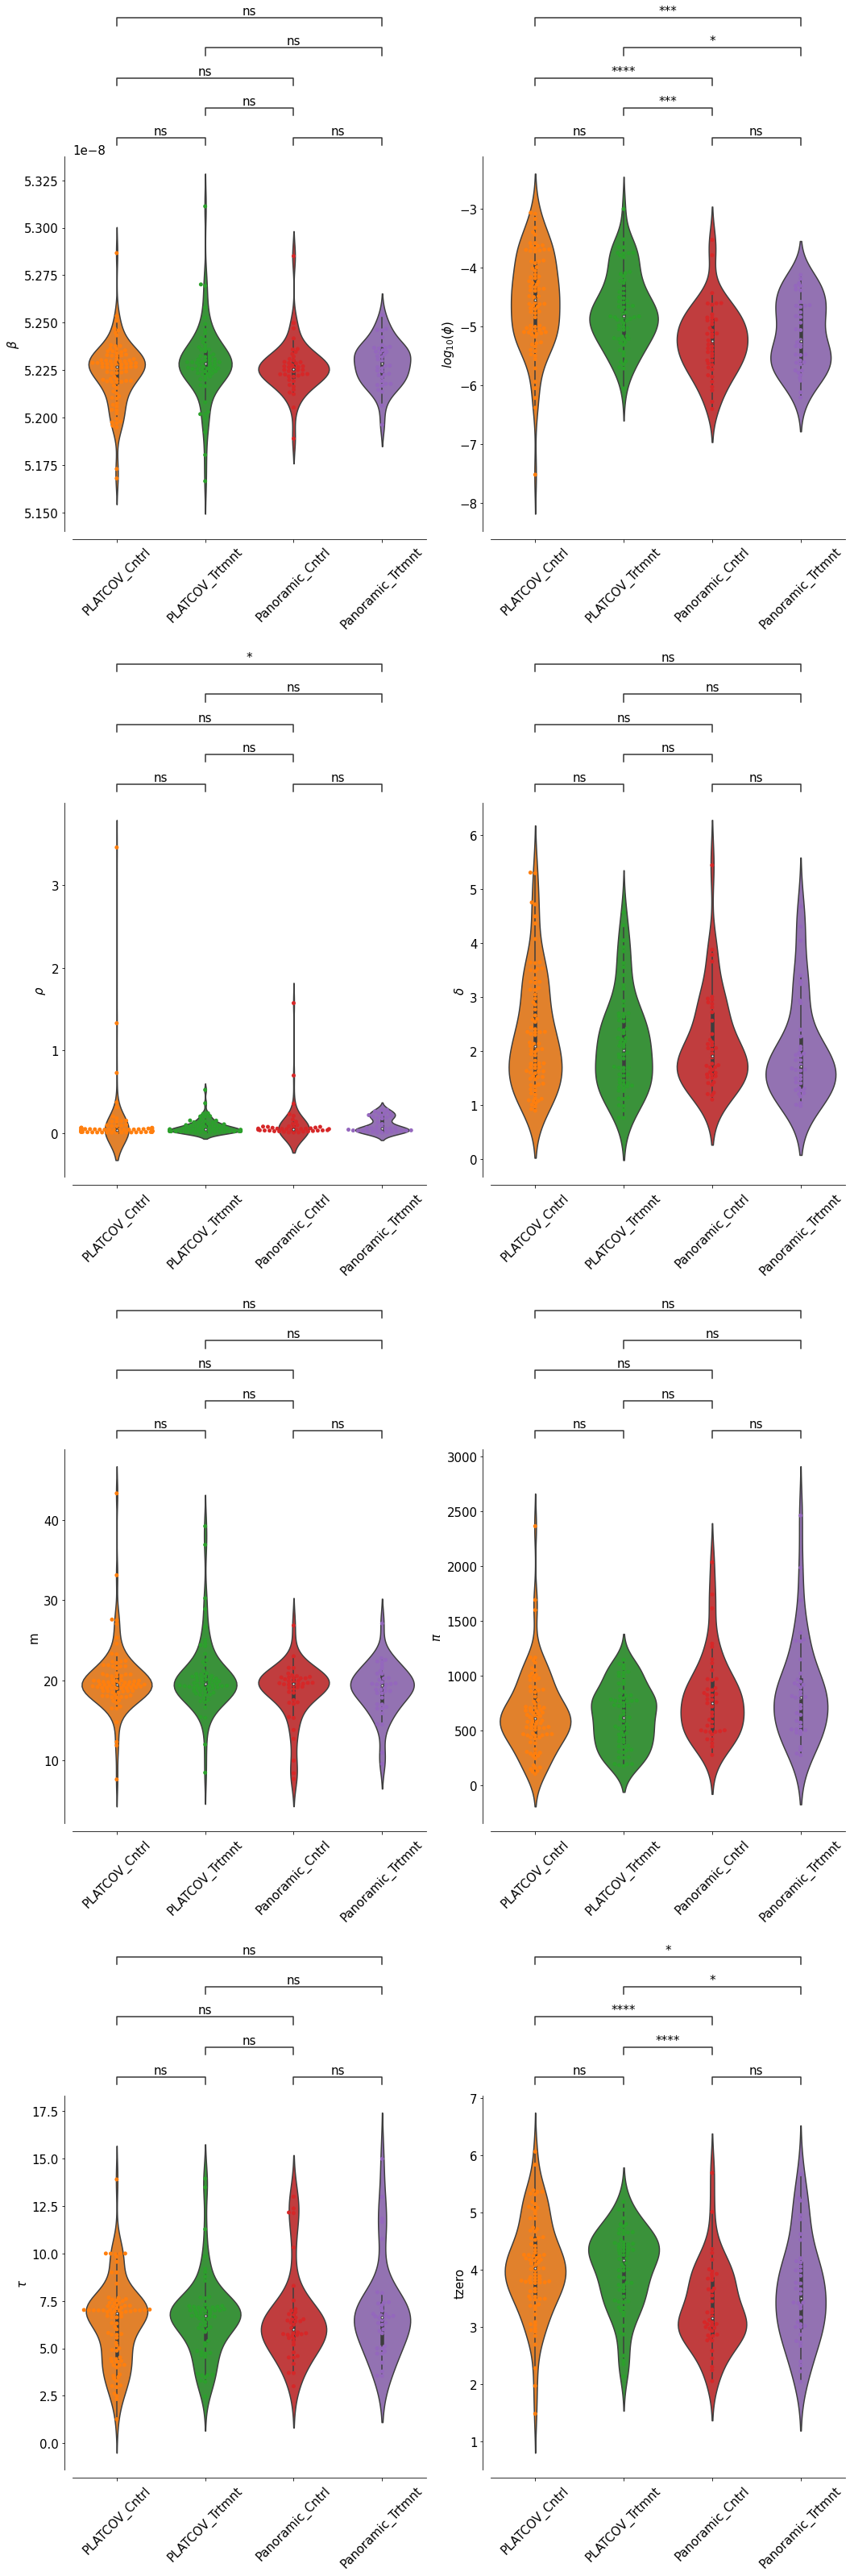

In [25]:
fig = plt.figure(figsize = (15,45))
plt.rcParams.update({'font.size': 15})
color = {'PLATCOV_Cntrl': 'tab:orange', 'PLATCOV_Trtmnt': 'tab:green', 'Panoramic_Cntrl': 'tab:red', 
         'Panoramic_Trtmnt': 'tab:purple'}
math_Sym = ['$\\beta$', '$log_{10}(\\phi)$', '$\\rho$', '$\\delta$', 'm', '$\\pi$', '$\\tau$', 'tzero']
for i, VLParam in enumerate(['beta', 'phi', 'rho', 'delta', 'm', 'pi', 'tau', 'tzero']):
    plt.subplot(4,2,i+1)
    ax = sns.swarmplot(x='Cohort', y=VLParam, data = param_DF, palette = color)
    ax= sns.violinplot(x='Cohort', y=VLParam, data = param_DF, palette = color)

 #   if VLParam == 'phi' or VLParam == 'tzero': 
   #     annotator = Annotator(ax, 
   #                           [('NBA', 'PLATCOV_Cntrl'), ('NBA', 'PLATCOV_Trtmnt')], 
   #                           data=param_DF, x='Cohort', y=VLParam)
   #     annotator.configure(test = 'Mann-Whitney', comparisons_correction="bonferroni", 
    #                        loc='outside').apply_and_annotate()
    #if VLParam == 'tau': 
    sns.despine(offset=10, trim=False)
    ax.set_ylabel(math_Sym[i])
    ax.set_xlabel('')
    ax.tick_params(axis='x', labelrotation=45)
    annotator = Annotator(ax, 
                          [('PLATCOV_Cntrl','PLATCOV_Trtmnt'),  
                           ('Panoramic_Cntrl','Panoramic_Trtmnt'), ('PLATCOV_Cntrl', 'Panoramic_Cntrl'), 
                          ('PLATCOV_Cntrl', 'Panoramic_Trtmnt'), ('PLATCOV_Trtmnt', 'Panoramic_Cntrl'),
                          ('PLATCOV_Trtmnt', 'Panoramic_Trtmnt')], 
                          data=param_DF, x='Cohort', y=VLParam)
    annotator.configure(test = 'Mann-Whitney', comparisons_correction="bonferroni", 
                        loc='outside').apply_and_annotate()
   
    for p in ax.patches:
        mybox =p
        color = mybox.get_facecolor()
        mybox.set_facecolor((0, 0, 0, 0))
        mybox.set_edgecolor('black')
        
plt.tight_layout(h_pad = 0., w_pad=0.0)
plt.savefig('NBA_PlATCOV_Panoramic_ParameterComp.svg')

In [68]:
param_DF_trtmnt=param_DF[(param_DF.Cohort!='NBA')&(param_DF.Cohort!='Panoramic_Cntrl')&(param_DF.Cohort!='PLATCOV_Cntrl')]

In [69]:
param_DF_trtmnt

,c,k,beta,pi,rho,phi,delta,m,tau,tzero,Vzero,Log10prf,Cohort
85,15,4,5.220114e-08,538.455726,0.034681,-6.05189,1.866830,18.4745,13.49030,2.90574,97,0.080993,PLATCOV_Trtmnt
86,15,4,5.216990e-08,394.448219,0.027012,-3.65771,0.907317,19.8976,6.99917,4.39024,97,0.077970,PLATCOV_Trtmnt
87,15,4,5.225646e-08,361.310015,0.057544,-4.67638,0.987214,19.8946,5.28160,3.73935,97,0.114267,PLATCOV_Trtmnt
88,15,4,5.252669e-08,1096.604440,0.359577,-3.76284,2.017790,36.9356,6.26335,4.09597,97,0.138776,PLATCOV_Trtmnt
89,15,4,5.227451e-08,770.938971,0.043954,-4.86950,2.702010,19.3982,6.36965,4.26003,97,0.096872,PLATCOV_Trtmnt
...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,15,4,5.217711e-08,918.121167,0.024532,-4.12643,2.893460,22.3676,6.79134,5.21203,97,0.065136,Panoramic_Trtmnt
226,15,4,5.253999e-08,1148.603142,0.003798,-4.38637,4.048870,20.0822,7.95823,4.88455,97,0.110350,Panoramic_Trtmnt
227,15,4,5.242277e-08,815.248484,0.032145,-4.66944,1.969070,21.5277,7.12290,4.95522,97,0.106048,Panoramic_Trtmnt
228,15,4,5.237210e-08,574.407365,0.108810,-4.31181,1.655250,21.1626,3.56028,4.20404,97,0.100534,Panoramic_Trtmnt


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

PLATCOV_Trtmnt vs. Panoramic_Trtmnt: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:9.918e-01 U_stat=1.237e+03


Text(37.25, 0.5, 'potency adjustment factor')

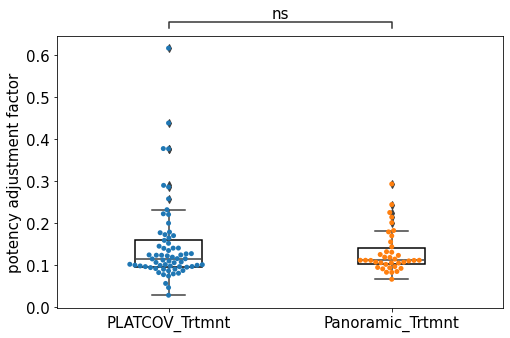

In [70]:
fig = plt.figure(figsize = (8,5))
plt.rcParams.update({'font.size': 15})
ax = sns.swarmplot(x='Cohort', y='Log10prf', data = param_DF_trtmnt)
ax = sns.boxplot(x='Cohort', y='Log10prf', data = param_DF_trtmnt, width=0.3)
ax.set_xlabel('')
annotator = Annotator(ax, 
                          [('Panoramic_Trtmnt','PLATCOV_Trtmnt')], 
                          data=param_DF_trtmnt, x='Cohort', y='Log10prf')
annotator.configure(test = 'Mann-Whitney', comparisons_correction="bonferroni", 
                    loc='outside').apply_and_annotate()
for p in ax.patches:
    mybox =p
    color = mybox.get_facecolor()
    mybox.set_facecolor((0, 0, 0, 0))
    mybox.set_edgecolor('black')
ax.set_ylabel('potency adjustment factor')
#ax.set_yticks([0.25, 0.5, 0.75, 1.0, 1.25, 1.5])
#ax.set_yticks([10,25,37, 50,61, 75,100])
#sns.despine(offset=10, trim=False)

Text(0, 0.5, 'potency adjustment factor')

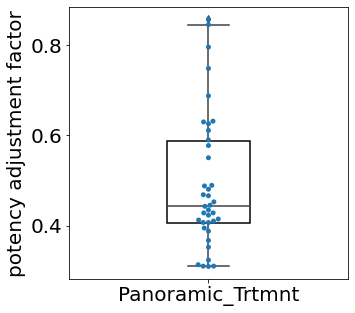

In [117]:
fig = plt.figure(figsize = (5,5))
plt.rcParams.update({'font.size': 20})
ax = sns.swarmplot(x='Cohort', y='Log10prf', data = param_DF[param_DF.Cohort == 'Panoramic_Trtmnt'])
ax = sns.boxplot(x='Cohort', y='Log10prf', data = param_DF[param_DF.Cohort == 'Panoramic_Trtmnt'], width=0.3)
ax.set_xlabel('')
for p in ax.patches:
    mybox =p
    color = mybox.get_facecolor()
    mybox.set_facecolor((0, 0, 0, 0))
    mybox.set_edgecolor('black')
ax.set_ylabel('potency adjustment factor')
#ax.set_yticks([0.25, 0.5, 0.75, 1.0, 1.25, 1.5])
#ax.set_yticks([10,25,37, 50,61, 75,100])
#sns.despine(offset=10, trim=False)

In [71]:
prf_Platcov = param_DF[param_DF.Cohort == 'PLATCOV_Trtmnt'].Log10prf.values
prf_Panoramic = param_DF[param_DF.Cohort == 'Panoramic_Trtmnt'].Log10prf.values

In [72]:
prf_mean_Platcov = np.mean(prf_Platcov)
prf_mean_Platcov

0.14527229542500866

In [73]:
prf_mean_Panoramic = np.mean(prf_Panoramic)
prf_mean_Panoramic

0.12921630531074912

In [74]:
prf_std_Platcov = np.std(prf_Platcov)
prf_std_Platcov

0.09663716624743071

In [75]:
prf_std_Panoramic = np.std(prf_Panoramic)
prf_std_Panoramic

0.049214909463397793

In [76]:
prf_median_Platcov = np.median(prf_Platcov)
prf_median_Platcov

0.11389325368854676

In [77]:
prf_median_Panoramic = np.median(prf_Panoramic)
prf_median_Panoramic

0.11035118470544385

In [78]:
IQR_25_Platcov = np.percentile(prf_Platcov, 25)
IQR_75_Platcov = np.percentile(prf_Platcov, 75)
prf_min_Platcov = np.min(prf_Platcov)
prf_max_Platcov = np.max(prf_Platcov)

In [79]:
IQR_25_Panoramic = np.percentile(prf_Panoramic, 25)
IQR_75_Panoramic = np.percentile(prf_Panoramic, 75)
prf_min_Panoramic = np.min(prf_Panoramic)
prf_max_Panoramic = np.max(prf_Panoramic)

In [80]:
IQR_25_Panoramic

0.10133303263821919

In [81]:
IQR_25_Platcov

0.09528619831242553

In [82]:
IQR_75_Panoramic

0.1395815638918903

In [83]:
IQR_75_Platcov

0.15774151223476662

In [84]:
prf_min_Platcov

0.027064499490384808

In [85]:
prf_min_Panoramic

0.06513583726532217

In [86]:
prf_max_Platcov

0.6156019686448959

In [87]:
prf_max_Panoramic

0.2920323747066356

(-8.0, 4.5)

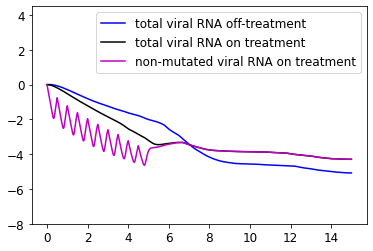

In [64]:
plt.plot(np.linspace(0, 14.999, 15000), Mean_drop_VL_TotPop_Cntrl_Panoramic, color = 'b', label = 'total viral RNA off-treatment')
plt.plot(np.linspace(0, 14.999, 15000), Mean_drop_VL_TotPop_Trtmnt_Panoramic, color = 'k', label = 'total viral RNA on treatment')
plt.plot(np.linspace(0, 14.999, 15000), Active_Mean_drop_VL_TotPop_Trtmnt_Panoramic, color = 'm', label = 'non-mutated viral RNA on treatment')
plt.legend()
plt.ylim([-8,4.5])

(-8.0, 4.5)

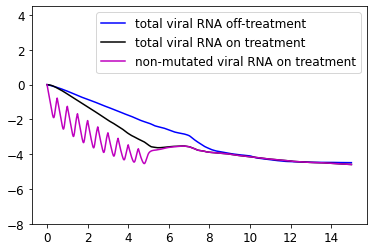

In [65]:
plt.plot(np.linspace(0, 14.999, 15000), Mean_drop_VL_TotPop_Cntrl_PLATCOV, color = 'b', label = 'total viral RNA off-treatment')
plt.plot(np.linspace(0, 14.999, 15000), Mean_drop_VL_TotPop_Trtmnt_PLATCOV, color = 'k', label = 'total viral RNA on treatment')
plt.plot(np.linspace(0, 14.999, 15000), Active_Mean_drop_VL_TotPop_Trtmnt_PLATCOV, color = 'm', label = 'non-mutated viral RNA on treatment')
plt.legend()
plt.ylim([-8,4.5])